# ARCLYTICS App Analytics  

This Jupyter Notebook is for doing some quick and dirty tests for running data analytics operations on the MongoDB and Redis data persistence. The purpose of which is to then put into a pipeline and then create endpoints for each type of query and analysis that can be done.

In [1]:
# Plotly imports

import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots

chart_studio.tools.set_credentials_file(
    username='codeninja55', 
    api_key='mLp691cLJDdKaNgJykR4'
)

chart_studio.tools.set_config_file(
    world_readable=True,
    sharing='public'
)

In [135]:
# imports
import datetime
from os import environ as env
from pymongo import MongoClient
import pandas as pd
from redis import Redis
import json 
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

In [136]:
# LaTeX Preamble and setting up output for reporting

# Add a logger 
# from logger.applogger import AppLogger
# logger = AppLogger("jupyterlab")

%matplotlib inline
sns.set(style='darkgrid')
# Context either: "paper", "notebook", "talk"
sns.set_context("paper", font_scale=1.0)
# matplotlib.use('PS')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (25,15)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 10

In [137]:
conn = MongoClient(env.get('MONGO_URI'))

db_name = 'arc_dev'
collection = 'users'
db = conn[db_name]

## Live Logged in Users

In [ ]:
date = datetime.datetime.utcnow().strftime('%Y-%m-%d')

pipeline = [
    {'$match': {'date': date}},
    {'$unwind': '$logged_in'},
    {
        '$project': {
            '_id': 0,
#             'date': '$date',
            'datetime': '$logged_in.datetime',
            'logged_in_users': '$logged_in.value'
        }
    }
]

res = db['celery_beat'].aggregate(pipeline)

df = pd.DataFrame(list(res))
df.dropna(inplace=True)

df['timestamp'] = pd.to_datetime(df['datetime'])
df.set_index('timestamp', inplace=True)

df

In [ ]:
fig = go.Figure()

trace = go.Scatter(x=df.index, y=df['logged_in_users'])

fig.add_trace(trace)

fig.update_layout(
  showlegend=False,
  title_text="Logged in Users",
#   xaxis_range=[
#     datetime.datetime(2019, 10, 4),
#     datetime.datetime(2019, 10, 5)
#   ],
  xaxis_rangeslider_visible=True
)

# fig.update_xaxes(dtick=1)
fig.update_yaxes=(tick0=0, dtick=1)

py.iplot(fig, filename='user_login_timestamps')

## Alloys Analysis

In [29]:

pipeline = [
    {'$unwind': '$saved_alloys'},
    {
        '$project': {
            '_id': 0,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
    {'$unwind': '$compositions'},
    {
        '$replaceRoot': {
            'newRoot': '$compositions'
        }
    },
    {
        '$group': {'_id': '$symbol', 'weight': {'$addToSet': '$weight'}}
    },
    {
        '$project': {
            'weight': 1,
            '_id': 1
        }
    }
]

res = db['users'].aggregate(pipeline)

df = pd.DataFrame(list(res))

df

,_id,weight
0,Fe,[0.0]
1,Nb,[0.0]
2,Ti,[0.0]
3,W,[0.0]
4,Ni,"[0.73, 0.37, 1.9, 0.97, 0.0, 0.5, 0.04, 0.67, ..."
5,Si,"[0.73, 2.22, 0.892, 0.66, 0.8, 0.86, 0.92, 0.7..."
6,V,"[0.08, 0.0]"
7,As,[0.0]
8,P,"[0.007, 0.0, 0.012]"
9,B,[0.0]


In [78]:
pipeline = [
    {'$unwind': '$saved_alloys'},
    {
        '$project': {
            '_id': 0,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
]

res = db['users'].aggregate(pipeline)

pd.DataFrame(list(res))

# for i in res:
#   print(i)

,name,compositions
0,Ionite,"[{'symbol': 'C', 'weight': 0.36}, {'symbol': '..."
1,Kayaleco,"[{'symbol': 'C', 'weight': 0.21}, {'symbol': '..."
2,Aegolong,"[{'symbol': 'C', 'weight': 0.6}, {'symbol': 'M..."
3,Chloneotime,"[{'symbol': 'C', 'weight': 0.31}, {'symbol': '..."
4,New Tech,"[{'symbol': 'C', 'weight': 0.53}, {'symbol': '..."
...,...,...
2366,New Alloy,"[{'symbol': 'C', 'weight': 0.5}, {'symbol': 'M..."
2367,Nanotech,"[{'symbol': 'C', 'weight': 0.344}, {'symbol': ..."
2368,alloy-987,"[{'symbol': 'C', 'weight': 0.32}, {'symbol': '..."
2369,Wakanda Vibranium,"[{'symbol': 'C', 'weight': 0.044}, {'symbol': ..."


In [210]:
pipeline = [
    {'$unwind': '$saved_alloys'},
    {
        '$project': {
            '_id': 1,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
    {'$unwind': { 'path': '$compositions', 'includeArrayIndex': 'arrayIndex'}},
    {
        '$group': {
            '_id': '$_id',
            'symbol': { '$push': { 'elem': '$compositions.symbol' } },
            'weight': { '$push': { 'wt': '$compositions.weight' } }
        }
    }
  
]

res = db['users'].aggregate(pipeline)

pd.DataFrame(list(res))

,_id,symbol,weight
0,5dabd0ee4057508cb545e051,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.5}, {'wt': 0.64}, {'wt': 0.87}, {'wt..."
1,5dabd0ee4057508cb545e024,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.56}, {'wt': 1.1}, {'wt': 0.13}, {'wt..."
2,5dabd0ee4057508cb545e005,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.21}, {'wt': 1.2}, {'wt': 0.43}, {'wt..."
3,5dabd0bf4057508cb545d03f,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.094}, {'wt': 1.03}, {'wt': 1.42}, {'..."
4,5dabd0bd4057508cb545cfca,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.31}, {'wt': 0.82}, {'wt': 0.43}, {'w..."
...,...,...,...
197,5dabd0e94057508cb545de78,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.3}, {'wt': 0.78}, {'wt': 1.6}, {'wt'..."
198,5dabd0e94057508cb545de27,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.12}, {'wt': 0.21}, {'wt': 0.892}, {'..."
199,5dabd0974057508cb545c260,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.32}, {'wt': 0.39}, {'wt': 0.83}, {'w..."
200,5dabd0ea4057508cb545deb7,"[{'elem': 'C'}, {'elem': 'Mn'}, {'elem': 'Si'}...","[{'wt': 0.044}, {'wt': 1.73}, {'wt': 0.22}, {'..."


In [236]:
pipeline = [
    {'$unwind': '$saved_alloys'},
  
    {
        '$project': {
            '_id': 1,
            'name': '$saved_alloys.name',
            'compositions': '$saved_alloys.compositions'
        }
    },
  
    {'$unwind': '$compositions'},
  
    {
        '$group': {
            '_id': { 'id': '$_id', 'name':  '$name' },
            'items': { 
                '$addToSet': { 'name': '$compositions.symbol', 'value': '$compositions.weight' } 
            },
        }
    },
  
    {
      '$project': {
          'tmp': {
              '$arrayToObject': {
                  '$zip': { 'inputs': [ "$items.name", "$items.value" ] }
              }
          }
      }
  },
  
  {
      '$addFields': { 'tmp.name': '$_id.name'}
  }, 
  
  { 
      '$replaceRoot': { 'newRoot': '$tmp' }
  }
]

res = db['users'].aggregate(pipeline)
df = pd.DataFrame(list(res))
df

,Fe,P,N,V,Ti,B,Mn,Nb,W,Cr,Si,Al,C,Mo,S,Ni,Cu,Co,As,name
0,0.0,0.012,0.000,0.00,0.0,0.0,0.84,0.0,0.0,0.20,0.38,0.0,0.600,0.00,0.040,0.04,0.23,0.5,0.0,Aegolong
1,0.0,0.000,0.000,0.00,0.0,0.0,1.73,0.0,0.0,0.00,0.22,0.0,0.044,0.26,0.000,0.00,0.00,0.0,0.0,Wakanda Vibranium
2,0.0,0.000,0.000,0.00,0.0,0.0,0.43,0.0,0.0,0.40,0.92,0.0,0.320,0.26,0.000,0.29,0.00,0.0,0.0,alloy-987
3,0.0,0.000,0.000,0.00,0.0,0.0,0.73,0.0,0.0,0.23,0.62,0.0,0.344,0.50,0.000,0.45,0.00,0.0,0.0,Nanotech
4,0.0,0.012,0.000,0.00,0.0,0.0,0.54,0.0,0.0,0.65,0.09,0.0,0.410,0.00,0.040,0.40,0.23,0.0,0.0,High Tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,0.0,0.012,0.000,0.00,0.0,0.0,0.64,0.0,0.0,0.51,0.66,0.0,0.770,0.00,0.040,0.73,0.23,0.5,0.0,Chemoebite
2367,0.0,0.007,0.011,0.08,0.0,0.0,0.80,0.0,0.0,1.34,0.60,0.0,0.730,1.10,0.003,0.20,0.00,0.0,0.0,Alloy3065
2368,0.0,0.000,0.000,0.00,0.0,0.0,1.98,0.0,0.0,0.00,2.22,0.0,0.044,0.26,0.000,0.00,0.00,0.0,0.0,Doom's day
2369,0.0,0.012,0.000,0.00,0.0,0.0,0.39,0.0,0.0,0.10,0.83,0.0,0.320,0.00,0.040,0.97,0.23,0.5,0.0,halodye


In [237]:
# Standardising the data
features = ['grain_size', 'ms_temp', 'ms_rate_param', 'bs_temp', 'ae1_temp', 'ae3_temp']

from sklearn.preprocessing import MinMaxScaler

# Separating out the target
labels_df = pd.DataFrame(data=df['name'].values, columns=['name'])
labels_df.reset_index(drop=True, inplace=True)

# Separating out the features
df.drop(['name'], axis=1, inplace=True)
X = df.loc[:].values

len(X)

2371

In [238]:
len(X[0])

19

In [239]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_embedded = tsne.fit_transform(X)

# create a new aggregated dataframe to store the results
tsne_df = pd.DataFrame(data=tsne_embedded, columns=['x-tsne', 'y-tsne'])
tsne_df.reset_index(drop=True, inplace=True)
tsne_df = pd.concat([tsne_df, labels_df], axis=1, ignore_index=True)
tsne_df.columns = ['x-tsne', 'y-tsne', 'name']


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2371 samples in 0.001s...
[t-SNE] Computed neighbors for 2371 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2371
[t-SNE] Computed conditional probabilities for sample 2000 / 2371
[t-SNE] Computed conditional probabilities for sample 2371 / 2371
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.140198
[t-SNE] KL divergence after 2000 iterations: -0.037990


In [240]:
import pprint

# Check the results
pprint.pprint(tsne.get_params())
print("t-SNE Data Shape: {}".format(str(tsne_df.shape)))
tsne_df.head()

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 2000,
 'n_iter_without_progress': 300,
 'perplexity': 40,
 'random_state': None,
 'verbose': 1}
t-SNE Data Shape: (2371, 3)


,x-tsne,y-tsne,name
0,-2.892131,16.017591,Aegolong
1,-4.343935,-5.011919,Wakanda Vibranium
2,-9.004156,-92.195213,alloy-987
3,-41.698002,28.573515,Nanotech
4,-43.841755,-59.570400,High Tech


In [241]:
tsne_plot = sns.scatterplot(x='x-tsne', y='y-tsne', data=tsne_df, hue='name')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)

ValueError: Could not interpret input 'method'

## Saved Simulations by Alloy

In [ ]:
pipeline = [
    {
        '$project': {
            '_id': 0,
        }
    }
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

In [ ]:
pipeline = [
    {
        '$replaceRoot': {
            'newRoot': '$simulation_results'
        }
    }   
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

In [ ]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'configs': '$configurations'
        }
    },
    {
        '$replaceRoot': {
            'newRoot': '$configs'
        }
    }   
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

In [ ]:
# Saved simulation by alloy name
pipeline = [
    {
        '$replaceRoot': {
            'newRoot': '$alloy_store.alloys.parent'
        }
    }   
]

res = db['saved_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

## Alloy Name Count

In [ ]:
# Saved simulation by alloy name
pipeline = [
    {
        '$project': {
            '_id': 0,
            'alloy': '$alloy_store.alloys.parent'
        }
    },
    {
        '$group': {
          '_id': '$alloy.name',
          'count': { '$sum': 1 }
        }
    },
]

res = db['saved_simulations'].aggregate(pipeline)
df = pd.DataFrame(list(res))
df

In [ ]:
# Saved simulation by alloy name
pipeline = [
    {
        '$project': {
            '_id': 0,
            'alloy': '$alloy_store.alloys.parent'
        }
    },
    {
        '$group': {
          '_id': '$alloy.name',
          'count': { '$sum': 1 }
        }
    },
]

res = db['shared_simulations'].aggregate(pipeline)
pd.DataFrame(list(res))

## MDS on Simulation Configurations

In [ ]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'method': '$configurations.method',
            'grain_size': '$configurations.grain_size',
            'ms_temp': '$configurations.ms_temp',
            'ms_rate_param': '$configurations.ms_rate_param',
            'bs_temp': '$configurations.bs_temp',
            'ae1_temp': '$configurations.ae1_temp',
            'ae3_temp': '$configurations.ae3_temp',
        }
    }
]

res = db['saved_simulations'].aggregate(pipeline)
df = pd.DataFrame(list(res))

df = pd.get_dummies(df)
df.head()

In [ ]:

iso = manifold.Isomap(n_neighbors=2, n_components=2)

iso.fit(df)

manifold_2Da = iso.transform(df)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])

# Left with 2 dimensions
manifold_2D.head()

In [ ]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(df)

plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [ ]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

out

In [ ]:
plt.scatter(out[:, 0], out[:, 1])
plt.axis('equal')

In [160]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'method': '$configurations.method',
            'grain_size': '$configurations.grain_size',
            'ms_temp': '$configurations.ms_temp',
            'ms_rate_param': '$configurations.ms_rate_param',
            'bs_temp': '$configurations.bs_temp',
            'ae1_temp': '$configurations.ae1_temp',
            'ae3_temp': '$configurations.ae3_temp',
        }
    }
]

res = db['saved_simulations'].aggregate(pipeline)
df = pd.DataFrame(list(res))


In [161]:
# Standardising the data
features = ['grain_size', 'ms_temp', 'ms_rate_param', 'bs_temp', 'ae1_temp', 'ae3_temp']

from sklearn.preprocessing import MinMaxScaler

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
labels_df = pd.DataFrame(data=df['method'].values, columns=['method'])
labels_df.reset_index(drop=True, inplace=True)

# An alternative standardization is scaling features to lie between a given minimum and maximum value, often between 
# zero and one, or so that the maximum absolute value of each feature is scaled to unit size. This can be achieved 
# using MinMaxScaler or MaxAbsScaler, respectively.
# The motivation to use this scaling include robustness to very small standard deviations of features and preserving 
# zero entries in sparse data.
minmax_scaler = MinMaxScaler()

# x = standard_scaler.fit_transform(x)
x = minmax_scaler.fit_transform(x)
x

array([[0.        , 0.45351041, 0.62903226, 0.61835163, 1.        ,
        0.4178658 ],
       [0.        , 0.95079178, 1.        , 0.90222004, 0.44132899,
        1.        ],
       [0.        , 1.        , 1.        , 0.91754368, 0.44132899,
        1.        ],
       ...,
       [0.        , 0.95079178, 1.        , 0.90222004, 0.44132899,
        1.        ],
       [0.        , 0.48390386, 0.62903226, 0.        , 1.        ,
        0.4178658 ],
       [0.        , 0.05832467, 0.        , 0.89742183, 0.66640407,
        0.        ]])

In [162]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principal_components = pca.fit_transform(x)
print("Components: {}".format(str(pca.components_)))
print("Variance: {}".format(str(pca.explained_variance_)))
print("Variance Ratio: {}".format(str(pca.explained_variance_ratio_)))

# create a new aggregated dataframe to store the results
pca_df = pd.DataFrame(data=principal_components, columns=['0', '1'])
pca_df.reset_index(drop=True, inplace=True)
pca_df = pd.concat([pca_df, labels_df], axis=1, ignore_index=True)
pca_df.columns = ['pc_1', 'pc_2', 'supplier']

pca_df.head()

Components: [[-0.         -0.5489567  -0.5597518  -0.06780523  0.20488222 -0.58202251]
 [-0.          0.05826663  0.08780855 -0.58318526  0.77949257  0.20293087]]
Variance: [0.41431746 0.12691352]
Variance Ratio: [0.68383843 0.20947306]


,pc_1,pc_2,supplier
0,0.281994,0.425165,Li98
1,-0.671167,0.003819,Li98
2,-0.699219,-0.002250,Kirkaldy83
3,1.032035,-0.223899,Kirkaldy83
4,-0.671167,0.003819,Li98


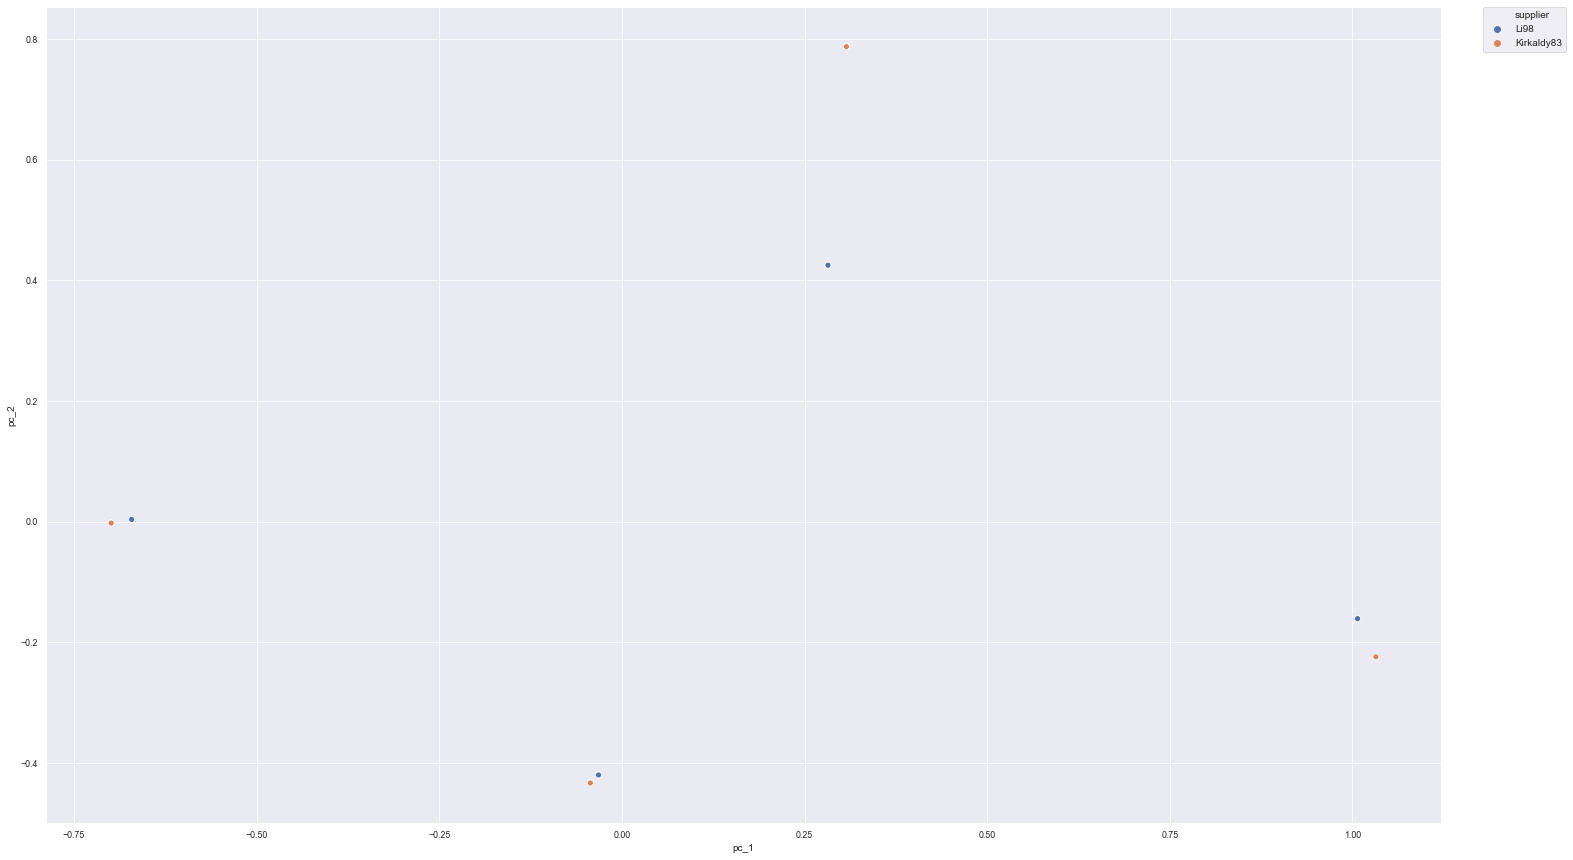

In [163]:
# Plotting the PCA
pca_plot = sns.scatterplot(x='pc_1', y='pc_2', data=pca_df, hue='supplier')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
# pca_plot.figure.savefig("plots/pca_plot-1.png")

In [164]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_embedded = tsne.fit_transform(x)

# create a new aggregated dataframe to store the results
tsne_df = pd.DataFrame(data=tsne_embedded, columns=['x-tsne', 'y-tsne'])
tsne_df.reset_index(drop=True, inplace=True)
tsne_df = pd.concat([tsne_df, labels_df], axis=1, ignore_index=True)
tsne_df.columns = ['x-tsne', 'y-tsne', 'method']

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1064 samples in 0.001s...
[t-SNE] Computed neighbors for 1064 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1064
[t-SNE] Computed conditional probabilities for sample 1064 / 1064
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 32.586693
[t-SNE] KL divergence after 2000 iterations: -0.040617


In [165]:
import pprint

# Check the results
pprint.pprint(tsne.get_params())
print("t-SNE Data Shape: {}".format(str(tsne_df.shape)))
tsne_df.head()

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 2000,
 'n_iter_without_progress': 300,
 'perplexity': 40,
 'random_state': None,
 'verbose': 1}
t-SNE Data Shape: (1064, 3)


,x-tsne,y-tsne,method
0,0.570783,-32.931080,Li98
1,-23.004627,3.847154,Li98
2,18.225039,0.872933,Kirkaldy83
3,-24.260855,52.080254,Kirkaldy83
4,-23.004627,3.847154,Li98


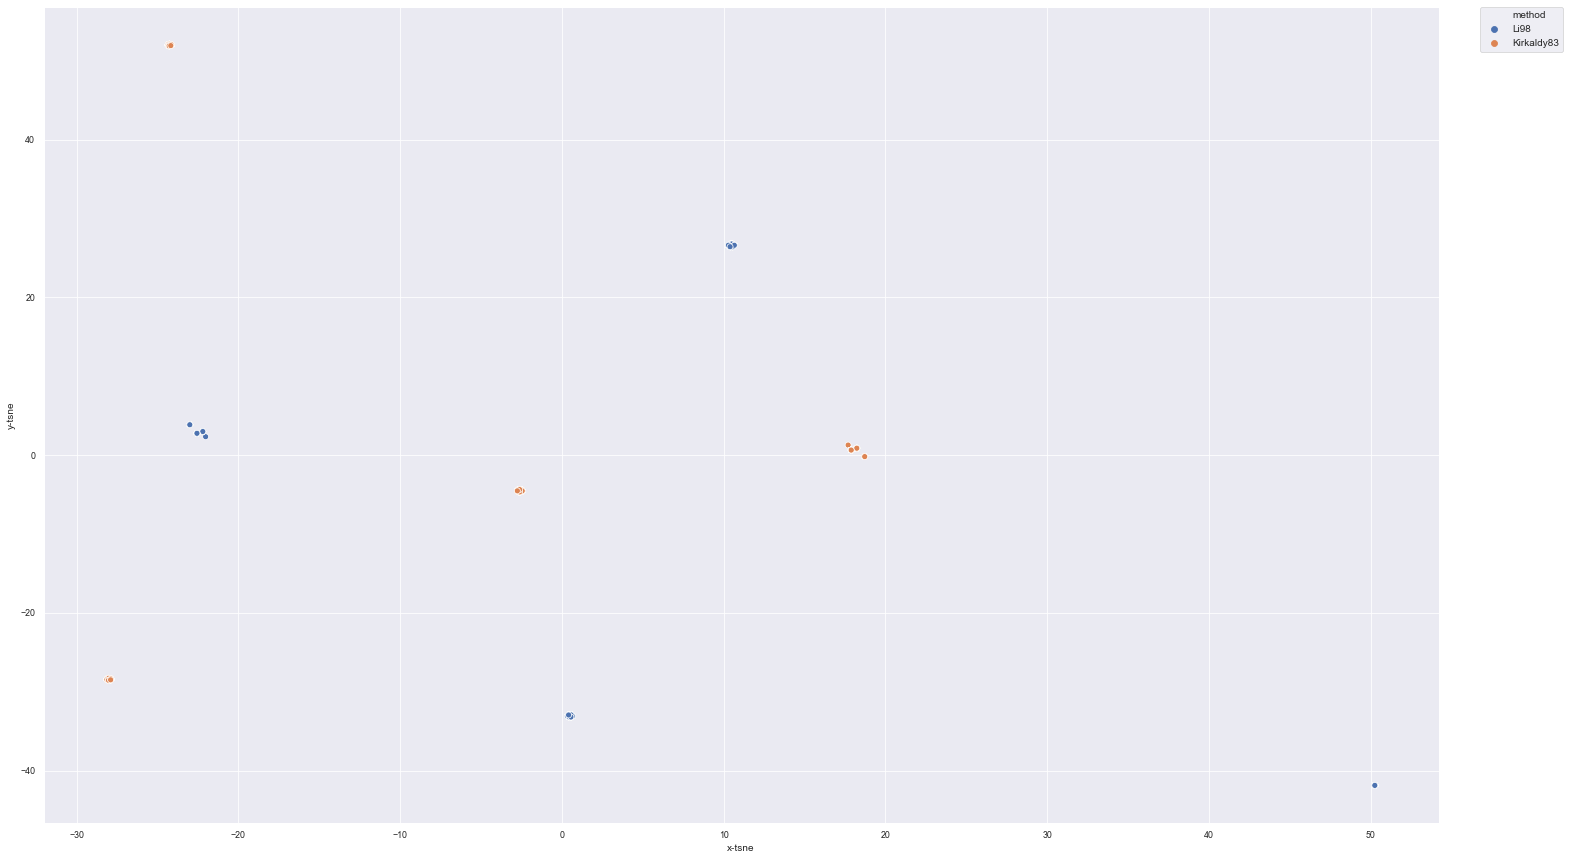

In [166]:
tsne_plot = sns.scatterplot(x='x-tsne', y='y-tsne', data=tsne_df, hue='method')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)